In [ ]:
import os
import itertools
import time
import random

import tensorflow as tf
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
)
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import (
    Input, Permute, LSTM, Bidirectional, Dense, Masking, Layer
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [ ]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU device not found. Đảm bảo bạn đã chọn runtime GPU.")
else:
    print(f"Found GPU at: {device_name}")

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [ ]:
def interpolate(data, mask=-1):
    d = []
    for seq in data:
        arr = [np.nan if x == mask else x for x in seq]
        df = pd.Series(arr).interpolate().fillna(method='bfill').fillna(method='ffill')
        d.append(df.values.tolist())
    return d

def data_normalize(seqs, mask=-1):
    normalized, scaling = [], []
    for seq in seqs:
        valid = [v for v in seq if v != mask]
        mn, mx = (min(valid), max(valid)) if valid else (0,1)
        norm = [((v - mn)/(mx - mn) if v != mask and mx != mn else v) for v in seq]
        normalized.append(norm)
        scaling.append((mn, mx))
    return normalized, scaling

def data_split(seqs, T_in, T_out, offset, stride):
    X, Y = [], []
    period = T_in + offset + T_out
    length = len(seqs[0])
    i = 0
    while i + period <= length:
        X.append([seq[i:i+T_in] for seq in seqs])
        Y.append([seq[i+T_in+offset:i+T_in+offset+T_out] for seq in seqs])
        i += stride
    return np.array(X), np.array(Y)

def split_train(intp, norm, T_in, T_out, offset, stride, start, end):
    L = len(intp[0])
    s, e = int(L*start), int(L*end)
    train_norm = [seq[:s] + seq[e:] for seq in norm]
    test_intp  = [seq[s:e] for seq in intp]
    train_x, train_y = data_split(train_norm, T_in, T_out, offset, stride)
    test_x,  test_y  = data_split(test_intp,  T_in, T_out, offset, stride)
    return train_x, train_y, test_x, test_y

def load_and_align_data(files, variables, mask=-1):
    idx = None
    for path in files.values():
        df = pd.read_csv(path, parse_dates=['datetime'], index_col='datetime').fillna(mask)
        idx = df.index if idx is None else idx.intersection(df.index)
    data, names = [], []
    for name, path in files.items():
        df = pd.read_csv(path, parse_dates=['datetime'], index_col='datetime').fillna(mask)
        for var in variables:
            if var in df:
                series = df.loc[idx, var].tolist()
                data.append(series)
                names.append(f"{name}_{var}")
    return data, names, idx

In [ ]:
def evaluate_predictions(preds, truths, idx, start, sensor_names=None):
    arr_p = np.array(preds)
    arr_t = np.array(truths)
    if arr_p.ndim == 2:
        arr_p = arr_p[:,:,None]
        arr_t = arr_t[:,:,None]
    N, H, C = arr_p.shape
    if sensor_names is None:
        sensor_names = [f"sensor{i+1}" for i in range(C)]
    s_idx = int(len(idx)*start)
    dates = pd.date_range(start=idx[s_idx], periods=H, freq=idx[1]-idx[0])
    results = {}
    for ci, name in enumerate(sensor_names):
        p = arr_p[:,:,ci].ravel()
        t = arr_t[:,:,ci].ravel()
        best_mae = np.inf
        best_sh = 0
        for sh in range(-20,1):
            rolled = np.roll(p,sh)
            if sh<0: rolled[sh:] = rolled[sh-1]
            mae = mean_absolute_error(t, rolled)
            if mae<best_mae:
                best_mae, best_sh = mae, sh
        pred_s = np.roll(p,best_sh)
        if best_sh<0: pred_s[best_sh:] = pred_s[best_sh-1]
        rmse = np.sqrt(mean_squared_error(t,pred_s))
        r2   = r2_score(t,pred_s)
        mape = mean_absolute_percentage_error(t+1e-10,pred_s+1e-10)*100
        print(f"{name}: shift={best_sh}, MAE={best_mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}, MAPE={mape:.2f}%")
        plt.figure(figsize=(10,4))
        plt.plot(dates, pred_s.reshape(-1,H)[0], label='Pred')
        plt.plot(dates, t.reshape(-1,H)[0], label='True')
        plt.title(name)
        plt.legend()
        plt.show()
        results[name] = {'shift':best_sh,'MAE':best_mae,'RMSE':rmse,'R2':r2,'MAPE':mape}
    return results

In [ ]:
def compute_target_weights(positions, target_pos, alpha=2.0, eps=1e-6):
    coords = np.array(list(positions.values()))
    dists = np.linalg.norm(coords - np.array(target_pos), axis=1)
    w = 1.0 / (dists**alpha + eps)
    return w / w.sum()

def build_multioutput_model(T_in, C, T_out,
                            tempor_units=64, spatial_units=32, lr=1e-4):
    inp = Input((T_in, C))
    # Temporal LSTM
    x = Bidirectional(LSTM(tempor_units, return_sequences=True))(inp)
    # Spatial LSTM
    x = Permute((2,1))(x)
    x = Bidirectional(LSTM(spatial_units, return_sequences=False))(x)
    # Predict all sensors
    out = Dense(T_out * C)(x)
    model = Model(inp, out)
    model.compile(loss='mean_absolute_error', optimizer=Adam(lr))
    return model

In [ ]:
def SP_Learner_multioutput(
    data_in, data_out,
    train_time, test_time, pred_offset, stride,
    start, end,
    tempor_units, spatial_units, lr
):
    # Normalize & interpolate
    norm_in, scale_in = data_normalize(data_in)
    intp_in = interpolate(norm_in)
    # train/test split
    tx, ty, vx, vy = split_train(intp_in, norm_in,
                                 train_time, test_time,
                                 pred_offset, stride,
                                 start, end)
    # reshape
    train_x = tx.transpose(0,2,1)
    train_y = ty.reshape(ty.shape[0], -1)
    val_x   = vx.transpose(0,2,1)
    val_y   = vy.reshape(vy.shape[0], -1)
    C = train_x.shape[2]
    # build & fit
    model = build_multioutput_model(train_time, C, test_time,
                                    tempor_units, spatial_units, lr)
    es = EarlyStopping('val_loss', patience=10, restore_best_weights=True)
    model.fit(train_x, train_y,
              epochs=50, batch_size=16,
              validation_split=0.2,
              callbacks=[es], verbose=1)
    # predict field
    pred_flat = model.predict(val_x, verbose=1)
    pred_field = pred_flat.reshape(-1, test_time, C)
    return pred_field, vy, scale_in, model

Predict 4 using 1,2,3

In [ ]:
if __name__ == '__main__':
    # parameters
    train_time = 335
    test_time = 30
    offset = 70
    stride = 15
    start, end = 0.8, 1.0

    variables = ['PM2_5.ug.m3.']
    base = '/content/1_mins/'
    files = {f'sensor{i}': f'{base}{i:02d}_01mins.csv' for i in range(1,5)}

    # load
    data_all, names_all, idx = load_and_align_data(files, variables)

    data_in  = [data_all[i] for i in [0,1,2,3]]
    data_out = [data_all[1]]
    positions = {'sensor1':(0,0), 'sensor2':(1,0), 'sensor3':(0.5,0.8), 'sensor4':(0.7,0.3)}

    # train multi-output
    pred_field, true_field, scale_params, model = SP_Learner_multioutput(
        data_in, data_out,
        train_time, test_time, offset, stride,
        start, end,
        tempor_units=64, spatial_units=32, lr=1e-4
    )

    # predict new location
    new_pos = (0.3, 0.4)
    w_new = compute_target_weights(positions, new_pos, alpha=2.0)
    # interpolate field -> (N_windows, test_time)
    pred_new = np.tensordot(pred_field, w_new, axes=([2],[0]))
    # example: print first window
    print('Predicted at new location, first window:', pred_new[0])

    # evaluate for sensor2
    # reshape pred_field for sensor2
    sens2_idx = 0  # adjust index if needed
    pred_y = pred_field[:,:,sens2_idx][:,None,:]
    true_y = true_field
    res = None
    # de-normalize inside evaluate_model if desired
    print('Done.')


<ipython-input-3-0c28b8c00753>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate().fillna(method='bfill').fillna(method='ffill')


Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 0.1128 - val_loss: 0.0247
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0369 - val_loss: 0.0237
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0343 - val_loss: 0.0206
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0321 - val_loss: 0.0211
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0322 - val_loss: 0.0203
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0308 - val_loss: 0.0193
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0308 - val_loss: 0.0189
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0298 - val_loss: 0.0192
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0287 - val_loss: 0.0188
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0300 - val_loss: 0.0188
Epoch 11/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0294 - val_loss: 0.0186
Epoch 12/50
312/312 ━━━━━━━━━━

In [ ]:
def save_predictions_to_csv(preds, filename, sensor_names=None):
    arr = np.array(preds)
    if arr.ndim == 2:
        # (N, H)  → làm thành (N, H, 1)
        arr = arr[:,:,None]
    N, H, C = arr.shape

    # chuẩn tên sensors
    if sensor_names is None:
        sensor_names = [f"sensor{i+1}" for i in range(C)]
    elif len(sensor_names) != C:
        raise ValueError("sensor_names length must match number of channels")


    # build dict cho DataFrame
    data = {}
    for ci, name in enumerate(sensor_names):
        for t in range(H):
            col = f"{name}_step_{t+1}"
            data[col] = arr[:, t, ci]

    df = pd.DataFrame(data)
    df.index.name = "window_idx"
    df.to_csv(filename)
    print(f"Saved predictions ({N} windows × {H} steps × {C} channels) to {filename}")


In [ ]:
save_predictions_to_csv(
    pred_new,
    "saved_prediction(target).csv",
    sensor_names=["new_location"]
)

Saved predictions (1536 windows × 30 steps × 1 channels) to saved_prediction(target).csv


In [ ]:
def spatial_leave_one_out(
    data_all, names_all, positions,
    train_time, test_time, offset, stride, start, end,
    tempor_units, spatial_units, lr, idx):
    from copy import deepcopy
    results = {}

    sensor_keys = [n.split('_')[0] for n in names_all]

    for hold_idx, hold_key in enumerate(sensor_keys):
        print(f"\n=== Hold-out: {hold_key} ===")
        neigh_idx = [i for i,k in enumerate(sensor_keys) if k!=hold_key]
        data_in  = [data_all[i] for i in neigh_idx]
        data_out = deepcopy(data_in)   # chúng ta cũng predict tất cả neighbor sensors
        positions_in = {k:positions[k] for k in sensor_keys if k!=hold_key}

        pred_field, true_field_neigh, scale_neigh, _ = SP_Learner_multioutput(
            data_in, data_out,
            train_time, test_time, offset, stride,
            start, end,
            tempor_units, spatial_units, lr
        )

        w_new = compute_target_weights(positions_in, positions[hold_key], alpha=2.0)
        pred_new = np.tensordot(pred_field, w_new, axes=([2],[0]))

        norm_hold, scale_hold = data_normalize([data_all[hold_idx]])
        intp_hold            = interpolate(norm_hold)
        _, _, _, true_hold = split_train(
            intp_hold, norm_hold,
            train_time, test_time,
            offset, stride,
            start, end
        )

        mn, mx = scale_hold[0]
        pred_denorm = pred_new * (mx-mn) + mn                  # (N, H)
        true_denorm = true_hold[:,0,:] * (mx-mn) + mn         # (N, H)

        res = evaluate_predictions(
            pred_denorm,
            true_denorm,
            idx,
            start,
            sensor_names=[hold_key]
        )
        results[hold_key] = res

    return results


=== Hold-out: sensor1 ===


<ipython-input-3-0c28b8c00753>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate().fillna(method='bfill').fillna(method='ffill')


Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 0.1047 - val_loss: 0.0247
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0362 - val_loss: 0.0251
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0347 - val_loss: 0.0202
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0321 - val_loss: 0.0199
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0311 - val_loss: 0.0194
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0302 - val_loss: 0.0212
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0293 - val_loss: 0.0190
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0300 - val_loss: 0.0198
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0292 - val_loss: 0.0181
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0282 - val_loss: 0.0181
Epoch 11/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0281 - val_loss: 0.0191
Epoch 12/50
312/312 ━━━━━━━━━━

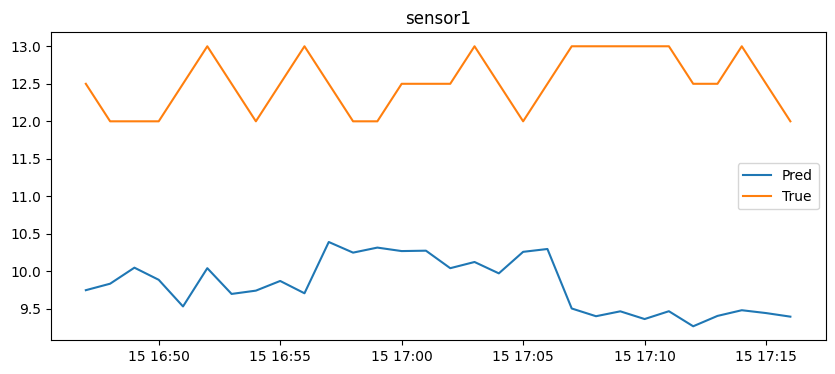


=== Hold-out: sensor2 ===


<ipython-input-3-0c28b8c00753>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate().fillna(method='bfill').fillna(method='ffill')


Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 0.1068 - val_loss: 0.0254
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0386 - val_loss: 0.0221
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0341 - val_loss: 0.0210
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0317 - val_loss: 0.0209
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0316 - val_loss: 0.0209
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 0.0303 - val_loss: 0.0200
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0305 - val_loss: 0.0209
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0301 - val_loss: 0.0191
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0296 - val_loss: 0.0191
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0302 - val_loss: 0.0186
Epoch 11/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0294 - val_loss: 0.0186
Epoch 12/50
312/312 ━━━━━━━━━━

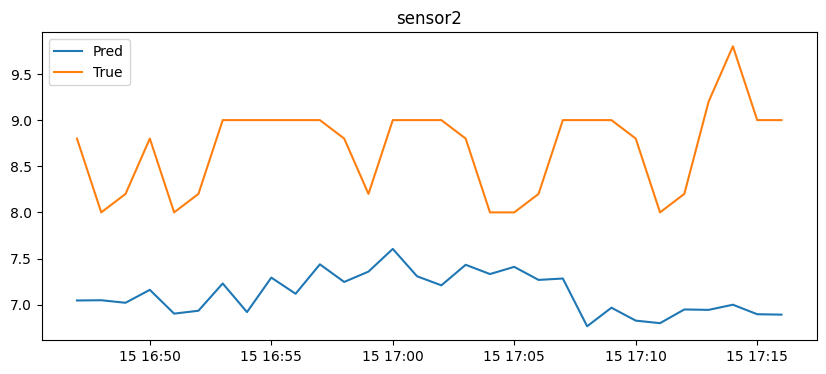


=== Hold-out: sensor3 ===


<ipython-input-3-0c28b8c00753>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate().fillna(method='bfill').fillna(method='ffill')


Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 0.1143 - val_loss: 0.0248
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0392 - val_loss: 0.0218
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0335 - val_loss: 0.0223
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0322 - val_loss: 0.0234
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0311 - val_loss: 0.0196
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0309 - val_loss: 0.0198
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0298 - val_loss: 0.0201
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0301 - val_loss: 0.0225
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0297 - val_loss: 0.0218
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0292 - val_loss: 0.0186
Epoch 11/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0288 - val_loss: 0.0195
Epoch 12/50
312/312 ━━━━━━━━━━

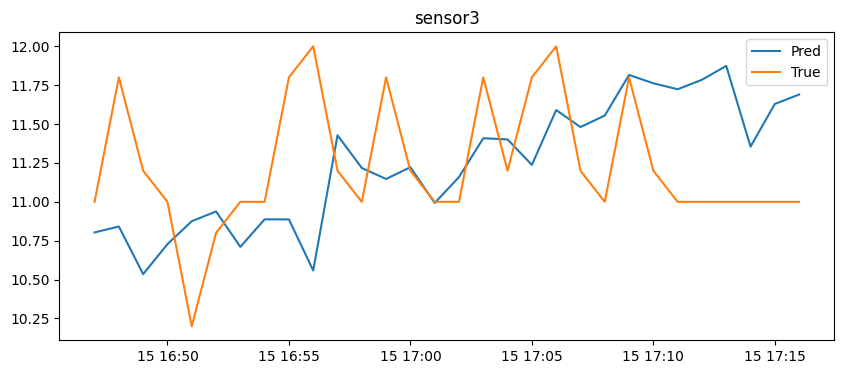


=== Hold-out: sensor4 ===


<ipython-input-3-0c28b8c00753>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.Series(arr).interpolate().fillna(method='bfill').fillna(method='ffill')


Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 0.1029 - val_loss: 0.0255
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0393 - val_loss: 0.0223
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0349 - val_loss: 0.0215
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0318 - val_loss: 0.0238
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0326 - val_loss: 0.0215
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0312 - val_loss: 0.0192
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0291 - val_loss: 0.0190
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0302 - val_loss: 0.0187
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0297 - val_loss: 0.0196
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0298 - val_loss: 0.0208
Epoch 11/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0291 - val_loss: 0.0198
Epoch 12/50
312/312 ━━━━━━━━━━

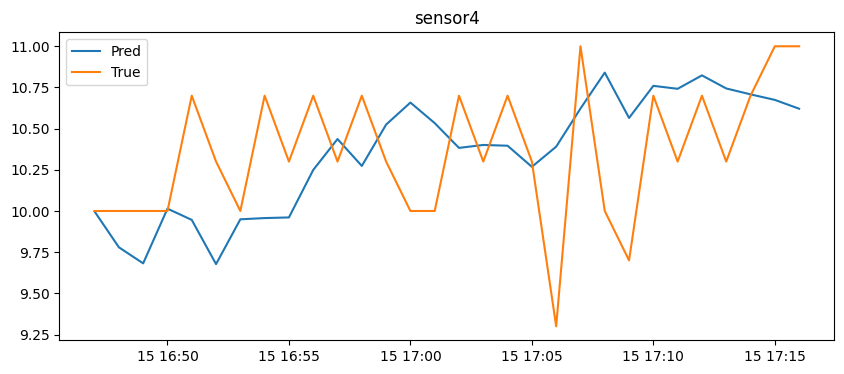


=== Leave-One-Out Results ===
sensor1 {'sensor1': {'shift': -20, 'MAE': 3.2107588803662996, 'RMSE': np.float64(6.135879047811016), 'R2': 0.856824957863647, 'MAPE': 13.1969950534457}}
sensor2 {'sensor2': {'shift': -20, 'MAE': 2.326336265908377, 'RMSE': np.float64(4.649935427359408), 'R2': 0.8559629580321195, 'MAPE': 13.725535604617278}}
sensor3 {'sensor3': {'shift': -20, 'MAE': 3.272568414604325, 'RMSE': np.float64(5.797453902278352), 'R2': 0.8596503917352215, 'MAPE': 17.20213050775799}}
sensor4 {'sensor4': {'shift': -20, 'MAE': 3.0786254352474676, 'RMSE': np.float64(5.8397328784362275), 'R2': 0.8483599648680499, 'MAPE': 14.317100748442643}}


In [ ]:
if __name__=='__main__':
    # … sau khi load data_all,names_all,idx và định nghĩa params …
    loo_metrics = spatial_leave_one_out(
        data_all, names_all, positions,
        train_time, test_time, offset, stride, start, end,
        tempor_units=64, spatial_units=32, lr=1e-4,
        idx=idx
    )
    print("\n=== Leave-One-Out Results ===")
    for sensor, m in loo_metrics.items():
        print(sensor, m)